In [2]:
import numpy as np
import pandas as pd
import sys
import re
import time
import datetime
from time import time, gmtime, strftime
from datetime import datetime
import statistics
from tqdm import tqdm_notebook as tqdm
from __future__ import division
from collections import Counter
from gensim import models
import gensim, logging
from gensim.models import Word2Vec
import pickle
import seaborn as sns
from copy import deepcopy

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, LeavePOut
from sklearn.linear_model import LogisticRegression, ElasticNet, SGDClassifier, LogisticRegressionCV, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, cohen_kappa_score, roc_auc_score, roc_curve, auc, mutual_info_score, average_precision_score, precision_recall_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize as tokenizer
import jellyfish
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell # no need of print for several objects!!!
InteractiveShell.ast_node_interactivity = "all"

#pd.set_option('display.height', 1000)
#pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

%matplotlib inline

init_vec = True

Using TensorFlow backend.


2 possibilities:
- Load and merge samples and labels.
- Load pre-built dataset.

(go to either of them with Ctrl+F)

#### Load and merge samples and labels.

In [2]:
path = '/media/hdd/salaun/wikiedit/annotations/data_v1/'

file_list = ['00_09_42',
             '00_09_73',
             '10_19_42',
             '20_24_42',
             '25_29_42',
             '30_34_42',
             '35_39_42',
             '40_44_42_uniq_parag',
             '40_44_42',
             '40_44_73',
             '45_49_42',
             '45_49_73',
             '50_54_42',
             '50_54_73',
             '55_59_42',
             '55_59_73',
             '60_65_42',
             '66-69_72_42',
             '66-69_72_73'
              ]

df_sample = pd.concat([pd.read_csv(path + file + '_sample.tsv', sep="\t") for file in file_list], ignore_index=True)
df_post_annot = pd.concat([pd.read_csv(path + file + '_post_annot_S.csv', sep=';', header=None) for file in file_list], ignore_index=True)
df_post_annot.columns = ['index', 'sample_id', 'raw_annot']

print('Number of files:', len(file_list))
df_sample.shape
df_post_annot.shape

Number of files: 19


(1900, 35)

(1900, 3)

In [3]:
# get dummies
print('Length df_sample:', len(df_sample))
print('Length df_post_annot:', len(df_post_annot))

labels_lists = ['ortho_gram_typo','wiki_formatting', 'vandal', 'reordering', 
              'revert_vandal', 'revert_other', 'content_remove', 'content_add',
              'nbr_wr', 'nbr_rw', 'nbr_x', 
              'semant_simil', 'semant_diff', 
              'other']

gross_labels_list = ['semant', 'nbr', 'semant_nbr']

for label in labels_lists:
    df_post_annot[label] = df_post_annot.raw_annot.str.contains(label)


for label in gross_labels_list: #initialization
    df_post_annot[label] = False


for i in range(0, df_post_annot.shape[0]):
    
    if df_post_annot.semant_simil.iloc[i]==True or df_post_annot.semant_diff.iloc[i]==True:
        df_post_annot.loc[i,'semant'] = True

    if df_post_annot.nbr_wr.iloc[i]==True or df_post_annot.nbr_rw.iloc[i]==True or df_post_annot.nbr_x.iloc[i]==True:
        df_post_annot.loc[i,'nbr'] = True  

    if df_post_annot.semant.iloc[i]==True or df_post_annot.nbr.iloc[i]==True:
        df_post_annot.loc[i,'semant_nbr'] = True    

df_post_annot.shape

Length df_sample: 1900
Length df_post_annot: 1900


(1900, 20)

In [4]:
print("DISTRIBUTION OF LABELS OVER ALL ANNOTATIONS \n")

df_annot_distrib = pd.DataFrame(index=labels_lists, columns=['absolute number', 'share of all observations'])
df_annot_distrib_bis = pd.DataFrame(index=gross_labels_list, columns=['absolute number', 'share of all observations'])

for label in labels_lists:
    df_annot_distrib.loc[label,'absolute number'] = (df_post_annot[label]==1).sum()
    df_annot_distrib.loc[label,'share of all observations'] = 100*((df_post_annot[label]==1).sum())/len(df_post_annot)
df_annot_distrib 
    
for label in gross_labels_list:
    df_annot_distrib_bis.loc[label,'absolute number'] = (df_post_annot[label]==1).sum()
    df_annot_distrib_bis.loc[label,'share of all observations'] = 100*((df_post_annot[label]==1).sum())/len(df_post_annot)
df_annot_distrib_bis   

DISTRIBUTION OF LABELS OVER ALL ANNOTATIONS 



,absolute number,share of all observations
ortho_gram_typo,506,26.6316
wiki_formatting,696,36.6316
vandal,114,6
reordering,91,4.78947
revert_vandal,12,0.631579
revert_other,6,0.315789
content_remove,116,6.10526
content_add,477,25.1053
nbr_wr,39,2.05263
nbr_rw,7,0.368421


,absolute number,share of all observations
semant,355,18.6842
nbr,48,2.52632
semant_nbr,403,21.2105


In [5]:
# merge inputs X (df_sample) with annotations Y (df_post_annot)
df_XY = pd.concat([df_sample, df_post_annot.loc[:,'raw_annot':'semant_or_nbr']], axis=1)
df_XY.shape
df_XY.columns
df_XY = df_XY.fillna('')
df_XY.tail(2)

(1900, 53)

Index(['Unnamed: 0', 'comment', 'filt_bot', 'filt_coher', 'filt_confli',
       'filt_contradic', 'filt_erreur', 'filt_erron', 'filt_faux',
       'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens',
       'filt_tromp', 'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format',
       'id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
       'modif', 'modif_add', 'modif_remove', 'parentid', 'registered',
       'sample_id', 'timestamp', 'title', 'user_id', 'username', 'raw_annot',
       'ortho_gram_typo', 'wiki_formatting', 'vandal', 'reordering',
       'revert_vandal', 'revert_other', 'content_remove', 'content_add',
       'nbr_wr', 'nbr_rw', 'nbr_x', 'semant_simil', 'semant_diff', 'other',
       'semant', 'nbr', 'semant_nbr'],
      dtype='object')

#### Load pre-built dataset.

In [ ]:
#df_XY.to_csv(path + 'full_dataset_with_all_labels.tsv', sep='\t')

In [3]:
path = '/media/hdd/salaun/wikiedit/annotations/data_v1/'
df_XY = pd.read_csv(path + 'full_dataset_with_all_labels.tsv', sep='\t')
df_XY.columns
df_XY = df_XY.loc[:,'comment':'semant_or_nbr']
df_XY.shape
df_XY.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'comment', 'filt_bot', 'filt_coher',
       'filt_confli', 'filt_contradic', 'filt_erreur', 'filt_erron',
       'filt_faux', 'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert',
       'filt_sens', 'filt_tromp', 'filt_typo', 'filt_vandalisme',
       'filt_vraise', 'format', 'id', 'id_file', 'id_modif',
       'label_incoherence', 'minor', 'model', 'modif', 'modif_add',
       'modif_remove', 'parentid', 'registered', 'sample_id', 'timestamp',
       'title', 'user_id', 'username', 'raw_annot', 'ortho_gram_typo',
       'wiki_formatting', 'vandal', 'reordering', 'revert_vandal',
       'revert_other', 'content_remove', 'content_add', 'nbr_wr', 'nbr_rw',
       'nbr_x', 'semant_simil', 'semant_diff', 'other', 'semant', 'nbr',
       'semant_or_nbr'],
      dtype='object')

(1900, 52)

Index(['comment', 'filt_bot', 'filt_coher', 'filt_confli', 'filt_contradic',
       'filt_erreur', 'filt_erron', 'filt_faux', 'filt_frappe', 'filt_gramma',
       'filt_ortho', 'filt_revert', 'filt_sens', 'filt_tromp', 'filt_typo',
       'filt_vandalisme', 'filt_vraise', 'format', 'id', 'id_file', 'id_modif',
       'label_incoherence', 'minor', 'model', 'modif', 'modif_add',
       'modif_remove', 'parentid', 'registered', 'sample_id', 'timestamp',
       'title', 'user_id', 'username', 'raw_annot', 'ortho_gram_typo',
       'wiki_formatting', 'vandal', 'reordering', 'revert_vandal',
       'revert_other', 'content_remove', 'content_add', 'nbr_wr', 'nbr_rw',
       'nbr_x', 'semant_simil', 'semant_diff', 'other', 'semant', 'nbr',
       'semant_or_nbr'],
      dtype='object')

#### Merge samples and labels.

Concentrate **"incoherent"** samples that are the strings in ***modif_remove*** in pairs labeled as ***semant_diff***

In [4]:
df_incoher = df_XY[['comment', 'filt_bot', 'filt_coher', 'filt_confli',
       'filt_contradic', 'filt_erreur', 'filt_erron', 'filt_faux',
       'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens',
       'filt_tromp', 'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format',
       'id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
       'modif_remove',
       'parentid', 'registered',
       'sample_id', 'timestamp', 'title', 'user_id', 'username', 'raw_annot']][df_XY.semant_diff].copy()
df_incoher = df_incoher.reset_index()
df_incoher = df_incoher.rename(columns = {'modif_remove':'string'})
df_incoher = pd.concat([df_incoher, pd.DataFrame({'incoherence':1}, index=df_incoher.index)], axis=1)

concentrate **"incoherent"** samples that are the strings in ***modif_add*** for pairs labeled as ***semant_diff***

and that are the strings in ***modif_*** for pairs labeled as ***semant_simil***

In [5]:
df_coher1 = df_XY[['comment', 'filt_bot', 'filt_coher', 'filt_confli','filt_contradic', 'filt_erreur', 'filt_erron',
                             'filt_faux','filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens','filt_tromp', 
                             'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format','id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
                             'modif_add',
                             'parentid', 'registered','sample_id', 'timestamp', 
                             'title', 'user_id', 'username', 'raw_annot']][df_XY.semant_diff].copy()
df_coher1 = df_coher1.rename(columns = {'modif_add':'string'})

df_coher2 = df_XY[['comment', 'filt_bot', 'filt_coher', 'filt_confli','filt_contradic', 'filt_erreur', 'filt_erron', 
                             'filt_faux','filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens','filt_tromp', 
                             'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format','id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
                             'modif_remove',
                             'parentid', 'registered','sample_id', 'timestamp', 
                             'title', 'user_id', 'username', 'raw_annot']][df_XY.semant_simil].copy()
df_coher2 = df_coher2.rename(columns = {'modif_remove':'string'})

df_coher3 = df_XY[['comment', 'filt_bot', 'filt_coher', 'filt_confli','filt_contradic', 'filt_erreur', 'filt_erron', 
                             'filt_faux','filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens','filt_tromp', 
                             'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format','id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
                             'modif_add',
                             'parentid', 'registered','sample_id', 'timestamp', 
                             'title', 'user_id', 'username', 'raw_annot']][df_XY.semant_simil].copy()
df_coher3 = df_coher3.rename(columns = {'modif_add':'string'})

df_coher = pd.concat([df_coher1,
                      df_coher2,
                      df_coher3],
                     axis = 0)

df_coher = df_coher.reset_index()

df_coher = pd.concat([df_coher, pd.DataFrame({'incoherence': 0}, index=df_coher.index)], axis=1)
#df_coher.columns = ['index', 'string', 'incoherence']

df = pd.concat([df_incoher, df_coher], axis=0, ignore_index=True)

Check homogeneity of each label group

In [6]:
df_incoher.incoherence.value_counts() # check if y_test == incoherence
df_coher.incoherence.value_counts()

1    143
Name: incoherence, dtype: int64

0    567
Name: incoherence, dtype: int64

In [7]:
df.incoherence.value_counts()
df.incoherence.value_counts(normalize=True)

0    567
1    143
Name: incoherence, dtype: int64

0    0.798592
1    0.201408
Name: incoherence, dtype: float64

In [8]:
df.shape
df.columns
df.tail(5)

(710, 35)

Index(['index', 'comment', 'filt_bot', 'filt_coher', 'filt_confli',
       'filt_contradic', 'filt_erreur', 'filt_erron', 'filt_faux',
       'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens',
       'filt_tromp', 'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format',
       'id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
       'string', 'parentid', 'registered', 'sample_id', 'timestamp', 'title',
       'user_id', 'username', 'raw_annot', 'incoherence'],
      dtype='object')

,index,comment,filt_bot,filt_coher,filt_confli,filt_contradic,filt_erreur,filt_erron,filt_faux,filt_frappe,filt_gramma,filt_ortho,filt_revert,filt_sens,filt_tromp,filt_typo,filt_vandalisme,filt_vraise,format,id,id_file,id_modif,label_incoherence,minor,model,string,parentid,registered,sample_id,timestamp,title,user_id,username,raw_annot,incoherence
705,1881,/* Biographie */,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,text/x-wiki,135429284,p5847438p6039053,18091,False,False,wikitext,Depuis septembre 2015 il coprésente l'émission...,133675156.0,False,p5847438p6039053_18091,2017-03-15T04:54:16Z,Christophe Jakubyszyn,NaN,86.195.68.196,semant_simil,0
706,1887,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,text/x-wiki,104218667,p5847438p6039053,133136,False,False,wikitext,'''Orlando Colón''' est un [[catcheur]] améric...,103717181.0,True,p5847438p6039053_133136,2014-05-29T18:03:10Z,Orlando Colón,1648983.0,Birki43,semant_simil,0
707,1889,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,text/x-wiki,74493635,p5847438p6039053,1206551,False,False,wikitext,Les Ordonnances manuélines (Ordenações Manueli...,74493611.0,True,p5847438p6039053_1206551,2012-01-18T10:56:24Z,Ordonnances manuélines,23243.0,Teolemon,"ortho_gram_typo, semant_simil",0
708,1893,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,text/x-wiki,34365984,p5847438p6039053,972379,False,False,wikitext,'''Oujda''' ([[arabe]] : ''wajda'' وجدة) est l...,34365556.0,True,p5847438p6039053_972379,2008-10-15T12:30:00Z,Oujda,210682.0,Barçawi,"wiki_formatting, content_add, semant_simil",0
709,1894,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,text/x-wiki,79013537,p5847438p6039053,1357657,False,False,wikitext,L'écartement des rails est 1000 mm et la tensi...,79013385.0,True,p5847438p6039053_1357657,2012-05-23T22:40:54Z,Tramway de Gand,584142.0,JG-Brill,"ortho_gram_typo, semant_simil",0


#### Filter editor-oriented text

In [9]:
string_pattern = '([a-zA-Z0-9ÀàÂâÆæÇçÈèÉéÊêËëÎîÏïÔôŒœÙùÛûÜü€₣]+|ref>|/ref>|\n\t|\'|[«».,\/#\|!$%\^&\*;:<>\[\]{}=\-_`~()])'

def wiki_normalize(s):
    s = re.sub(r'\[\[(?:[^\]|]*\|)?([^\]|]*)\]\]', r'\1', s.strip().lower())

    for element in [',', "pdf", "refnec", "référence nécessaire", "référence souhaitée", "..."]:
        s = s.replace("{{"+element+"}}","")
    s = re.sub(r'\{\{(?:[^\}|]*\|)?([^\}|]*)\}\}', r'\1', s.strip().lower())
    # remove {{ }} and remove {{a| from 

    #s = re.sub("\[[^\|]+\]", ' ', s.strip().lower())
    for element in ['\n', "'''''", "''''", "'''", "''"]:
        s = s.replace(element, " ")

    
    s = re.sub('<ref[^<]+</ref>', ' ', s) # https://stackoverflow.com/questions/12225729/regex-to-remove-text-between-tags-in-notepad
    

    s = re.sub('\{\{[^\|]+\|', ' ', s) # in {{a|b}} remove {{a| that is left ({{ and | are already removed)

    s = re.sub('<[^>]*>', ' ', s)
    s = re.sub('\[http[^\s]+\s', ' ', s)
    
    for element in ['|','{{', '}}', 'formatnum:','[...]', '[',']']:
        s = s.replace(element, " ")
        
    return s

def text_input_builder_bow(path):
    string_pattern = '([a-zA-Z0-9ÀàÂâÆæÇçÈèÉéÊêËëÎîÏïÔôŒœÙùÛûÜü€₣]+|ref>|/ref>|\n\t|«»\'|[.,\/#\|!$%\^&\*;:<>\[\]{}=\-_`~()])'
    content = []
    i=0
    for line in open(path, "r+").readlines():   
        if not line.startswith('<') and not line.isspace():
            i+=1
            line = line.lower()
            line = wiki_normalize(line)
            line = re.findall(string_pattern, line) # turns line to list where all tokens are split
            line = " ".join(line) # all tokens are gathered in one string again with whitespaces as separators
            content.append(line)
        #if i == 400000:
        #    break
    return content

In [10]:
df.columns

Index(['index', 'comment', 'filt_bot', 'filt_coher', 'filt_confli',
       'filt_contradic', 'filt_erreur', 'filt_erron', 'filt_faux',
       'filt_frappe', 'filt_gramma', 'filt_ortho', 'filt_revert', 'filt_sens',
       'filt_tromp', 'filt_typo', 'filt_vandalisme', 'filt_vraise', 'format',
       'id', 'id_file', 'id_modif', 'label_incoherence', 'minor', 'model',
       'string', 'parentid', 'registered', 'sample_id', 'timestamp', 'title',
       'user_id', 'username', 'raw_annot', 'incoherence'],
      dtype='object')

#### Check string length character and token-wise

In [11]:
for i in range(0, len(df)):
    df.loc[i,'string'] = wiki_normalize(df.loc[i,'string'])
    df.loc[i,'len'] = len(df.loc[i,'string'])
    df.loc[i,'len_tok'] = len(re.findall(string_pattern, df.loc[i, 'string'].strip().lower()))
    
df[['len']].describe()
df[['len_tok']].describe()

,len
count,710.000000
mean,594.595775
std,636.089970
min,22.000000
25%,209.250000
50%,401.000000
75%,722.000000
max,4795.000000


,len_tok
count,710.000000
mean,120.284507
std,127.517683
min,6.000000
25%,43.000000
50%,82.000000
75%,148.750000
max,969.000000


#### Check homogeneity of length (character and token wise) between label groups

In [12]:
df[['len']][df.incoherence == 0].describe()
df[['len']][df.incoherence == 1].describe()

,len
count,567.000000
mean,616.550265
std,636.822160
min,25.000000
25%,213.500000
50%,407.000000
75%,764.500000
max,4795.000000


,len
count,143.000000
mean,507.545455
std,627.844858
min,22.000000
25%,179.500000
50%,366.000000
75%,584.500000
max,4665.000000


In [13]:
df[['len_tok']][df.incoherence == 0].describe()
df[['len_tok']][df.incoherence == 1].describe()

,len_tok
count,567.000000
mean,124.407407
std,127.636388
min,6.000000
25%,43.500000
50%,83.000000
75%,156.000000
max,969.000000


,len_tok
count,143.000000
mean,103.937063
std,126.164783
min,6.000000
25%,37.000000
50%,74.000000
75%,114.000000
max,942.000000


#### Character-length distribution

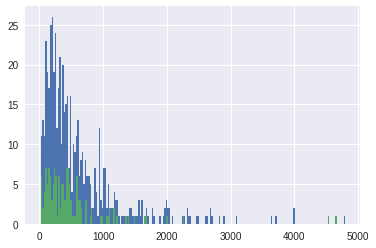

In [14]:
df[df.incoherence == 0].len.hist(bins=200)
df[df.incoherence == 1].len.hist(bins=200)

#### Token-length distribution

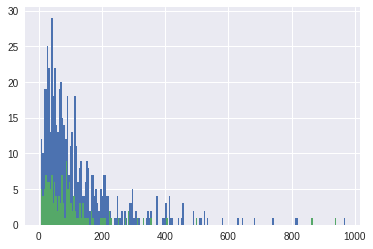

In [15]:
df[df.incoherence == 0].len_tok.hist(bins=200)
df[df.incoherence == 1].len_tok.hist(bins=200)

#### Language models (LM)

Run the cell below if the LM is not available (vector size = 100)

In [ ]:
'''
model100
%%monitor_cell language_model_100

import gensim, logging
from gensim.models import Word2Vec
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
path = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'

content_input = text_input_builder_bow(path) # list where each sentence is a string

new_input = [string.split() for string in content_input] # list where each sentence is a list

# input_sentences must be list of lists of tokens
# https://rare-technologies.com/word2vec-tutorial/
model = Word2Vec(new_input, hs=1, negative=0)

#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')
'''

Load pre-defined model (vector size = 100)

In [444]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')

"\nmodel100\n%%monitor_cell language_model_100\n\nimport gensim, logging\nfrom gensim.models import Word2Vec\nlogging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)\npath = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'\n\ncontent_input = text_input_builder_bow(path) # list where each sentence is a string\n\nnew_input = [string.split() for string in content_input] # list where each sentence is a list\n\n# input_sentences must be list of lists of tokens\n# https://rare-technologies.com/word2vec-tutorial/\nmodel = Word2Vec(new_input, hs=1, negative=0)\n\n#model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')\n"

In [24]:
len(model.wv.vocab)

729651

Run the cell below if the LM is not available (vector size = 300)

In [ ]:
"""
model300
%%monitor_cell language_model_300

import gensim, logging
from gensim.models import Word2Vec
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
path = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'

#content_input = text_input_builder_bow(path) # list where each sentence is a string

#new_input = [string.split() for string in content_input] # list where each sentence is a list

# input_sentences must be list of lists of tokens
# https://rare-technologies.com/word2vec-tutorial/
model = Word2Vec(new_input, size=300, hs=1, negative=0)

model.save('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')
"""

Load pre-defined model (vector size = 300)

In [16]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')

#### Compute LM scores

In [17]:
df['score'] = 'NaN'
for row in range(0, df.shape[0]):
    s = df.loc[row,'string']
    df.loc[row, 'score'] = model.score([re.findall(string_pattern, s.strip().lower())])[0]
    df.loc[row, 'prob'] = np.exp(df.loc[row, 'score'])

In [18]:
df.describe()

,index,id,id_modif,parentid,user_id,incoherence,len,len_tok,prob
count,710.000000,7.100000e+02,7.100000e+02,7.100000e+02,4.200000e+02,710.000000,710.000000,710.000000,7.100000e+02
mean,979.270423,6.503335e+07,7.723672e+05,6.430306e+07,4.920554e+05,0.201408,594.595775,120.284507,4.868470e-17
std,579.034024,3.635788e+07,4.243845e+05,3.606699e+07,5.078479e+05,0.401335,636.089970,127.517683,1.102084e-15
min,0.000000,1.366927e+06,8.500000e+02,1.336409e+06,3.260000e+02,0.000000,22.000000,6.000000,0.000000e+00
25%,439.750000,3.586803e+07,4.282098e+05,3.564341e+07,1.204830e+05,0.000000,209.250000,43.000000,0.000000e+00
50%,1028.000000,6.014793e+07,7.735620e+05,5.883866e+07,3.264895e+05,0.000000,401.000000,82.000000,0.000000e+00
75%,1513.000000,9.334835e+07,1.131114e+06,9.145190e+07,7.015760e+05,0.000000,722.000000,148.750000,0.000000e+00
max,1894.000000,1.388645e+08,2.589875e+06,1.388645e+08,2.609867e+06,1.000000,4795.000000,969.000000,2.912112e-14


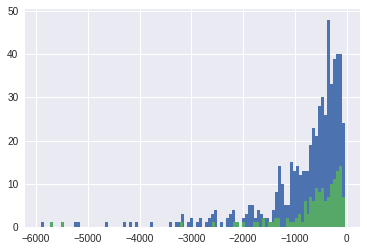

In [20]:
df[df["incoherence"]==0].score.hist(bins=100)
df[df["incoherence"]==1].score.hist(bins=100)

## Split train/test 

In [21]:
df_train = df.sample(frac=0.8)#,random_state=42)
df_test = df.drop(df_train.index).copy()
df_train = df_train.reset_index(drop=True).copy()
df_test = df_test.reset_index(drop=True).copy()
df_train = df_train.fillna('')
df_test = df_test.fillna('')

print('Distribution of labels in TRAIN set')
df_train.incoherence.value_counts()
df_train.incoherence.value_counts(normalize=True)
print('\n')
print('Distribution of labels in TEST set')
df_test.incoherence.value_counts()
df_test.incoherence.value_counts(normalize=True)

Distribution of labels in TRAIN set


0    448
1    120
Name: incoherence, dtype: int64

0    0.788732
1    0.211268
Name: incoherence, dtype: float64



Distribution of labels in TEST set


0    119
1     23
Name: incoherence, dtype: int64

0    0.838028
1    0.161972
Name: incoherence, dtype: float64

In [22]:
df_train.shape
df_test.shape

(568, 37)

(142, 37)

#### Functions

Choose either <code>cv_SKF</code>, <code>cv_RSKF</code> or <code>cv_LPO</code> for cross-validation setting.

In [110]:
cv_SKF = StratifiedKFold(n_splits=6, shuffle=True)
cv_RSKF = RepeatedStratifiedKFold(n_splits=6)
cv_LPO = LeavePOut(1)


def cross_val_series(X, y, clf, cv_input):
    
    metrics_list = ['precision', 'recall', 'f1', 'roc_auc'] #, 'neg_log_loss'
    df_scores = pd.DataFrame(index=metrics_list, columns=['score'])
    
    for metric in metrics_list:
        df_scores.loc[metric,'score'] = '{:.3f} (+/- {:.3f})'.format(cross_val_score(clf, X, y, cv=cv_input, scoring=metric).mean(), 1.96 * cross_val_score(clf, X, y, cv=cv_input, scoring=metric).std() / np.sqrt(len(cross_val_score(clf, X, y, cv=cv_input, scoring=metric))))
    return df_scores

Testing function.

In [64]:
def model_testing(X_train, y_train, X_test, y_test, model):
    
    metrics_list = ['precision', 'recall', 'f1', 'roc_auc']
    df_scores_test = pd.DataFrame(index=metrics_list, columns=['test_score'])
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    y_pred_proba = model.predict_proba(X_test)
    
    
    df_scores_test.loc['precision', 'test_score'] = '{:.3f}'.format(precision_score(y_test, y_pred))
    df_scores_test.loc['recall', 'test_score'] = '{:.3f}'.format(recall_score(y_test, y_pred))
    df_scores_test.loc['f1', 'test_score'] = '{:.3f}'.format(f1_score(y_test, y_pred))
    df_scores_test.loc['roc_auc', 'test_score'] = '{:.3f}'.format(roc_auc_score(y_test, y_pred_proba[:,1], average='weighted'))
    
    full_test_df = df_test.copy()
    full_test_df['y_test'] = pd.DataFrame(y_test)
    full_test_df['y_pred'] = pd.DataFrame(y_pred)
    full_test_df['y_pred_proba'] = pd.DataFrame(y_pred_proba[:,1])
    
    return df_scores_test, full_test_df, y_test, y_pred, y_pred_proba

Plot ROC curve.

In [65]:
def plot_roc_auc(y_test, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1], pos_label=1)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

## Method 1: BOW

Build new model (cell below) or load pre-existing model (next cell below)

In [466]:
%%time
#path = '/media/hdd/sileo/wiki-fr/text/full_filtered_wiki.txt'
#txt_input = text_input_builder_bow(path)
#vectorizer = CountVectorizer(max_features=8192)
#vectorizer.fit(txt_input)
#pickle.dump(vectorizer, open("vectorizer_bow.p", "wb"))

CPU times: user 14min 36s, sys: 5.79 s, total: 14min 42s
Wall time: 14min 43s


In [405]:
vectorizer = pickle.load(open( "/home/dp/notebooks/vectorizer_bow.p", "rb" ))

In [406]:
print('Voc length: {:,}'.format(len(vectorizer.vocabulary_))) # max = 2,431,546

X_train = vectorizer.transform(df_train.string).toarray()
X_test = vectorizer.transform(df_test_temp.string).toarray()

y_train = df_train.incoherence.values.copy()
y_test = df_test.incoherence.values.copy()

Voc length: 4,096


#### Logistic regression

In [409]:
clf = LogisticRegression(solver='sag', n_jobs=-1, C=0.0000001)#, max_iter = 1000)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: Th

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The ma

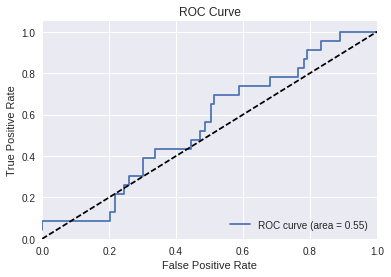

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.550 (+/- 0.049)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.551


In [70]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [ ]:
logreg_bow_df = full_test_df.copy()

0    23
Name: y_pred, dtype: int64

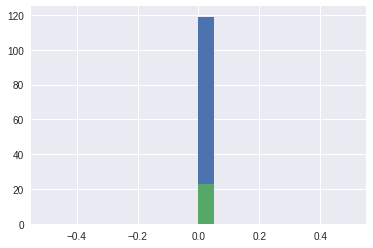

In [72]:
logreg_bow_df[logreg_bow_df.y_test == 0].y_pred.hist(bins=20)
logreg_bow_df[logreg_bow_df.y_test == 1].y_pred.hist(bins=20)
logreg_bow_df[logreg_bow_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

In [74]:
full_test_df[['y_test','y_pred_proba']]

,y_test,y_pred_proba
0,1,0.351501
1,1,0.351557
2,1,0.351591
3,1,0.351553
4,1,0.351670
5,1,0.351603
6,1,0.351618
7,1,0.351625
8,1,0.351603
9,1,0.351562


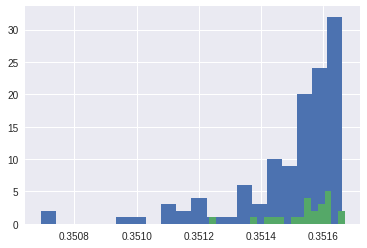

In [73]:
logreg_bow_df[logreg_bow_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg_bow_df[logreg_bow_df.y_test == 1].y_pred_proba.hist(bins=20)

#### Decision Tree classifier

In [196]:
clf = DecisionTreeClassifier()#criterion='entropy', splitter='random', class_weight='balanced')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

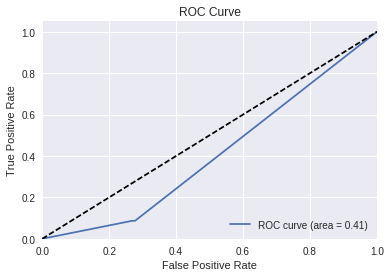

,score
precision,0.098 (+/- 0.091)
recall,0.083 (+/- 0.033)
f1,0.069 (+/- 0.032)
roc_auc,0.451 (+/- 0.048)


,test_score
precision,0.059
recall,0.087
f1,0.070
roc_auc,0.405


In [101]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [ ]:
dt_bow_df = full_test_df.copy()

0    21
1     2
Name: y_pred, dtype: int64

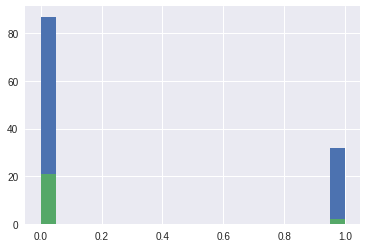

In [102]:
dt_bow_df[dt_bow_df.y_test == 0].y_pred.hist(bins=20)
dt_bow_df[dt_bow_df.y_test == 1].y_pred.hist(bins=20)
dt_bow_df[dt_bow_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

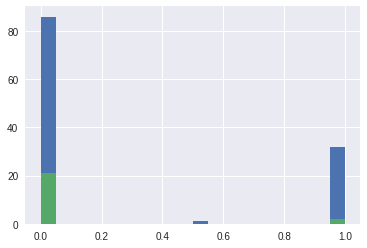

In [103]:
dt_bow_df[dt_bow_df.y_test == 0].y_pred_proba.hist(bins=20)
dt_bow_df[dt_bow_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [162]:
dt_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt_bow_df.y_test==1].sort_values('y_pred_proba', ascending=True)
dt_bow_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
for i in [5,22]:
    print(dt_bow_df.loc[i,'string'])

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,la tomate ( solanum lycopersicum l.) est un...,1,1,0,0.0,587.0,118.0
20,orleans est un comté au nord-ouest de l'état d...,1,1,0,0.0,187.0,43.0
19,le sous-secteur de jausiers du secteur forti...,1,1,0,0.0,978.0,201.0
18,kovu apparait au cinéma pour la première fois ...,1,1,0,0.0,656.0,155.0
17,"un peu plus de vingt ans plus tard, l'as de pi...",1,1,0,0.0,558.0,101.0
16,alles fühlt des liebe freuden (littéralement...,1,1,0,0.0,220.0,44.0
15,"médine , de son vrai nom médine zaouiche es...",1,1,0,0.0,286.0,57.0
14,la ligue libérale et patriotique (en anglais...,1,1,0,0.0,1092.0,210.0
13,stapfer divisa son ministère en quatre section...,1,1,0,0.0,366.0,78.0
12,(depuis 2007) : vacant,1,1,0,0.0,22.0,6.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
5,l'activité économique de la ville est essntiel...,1,1,1,1.0,311.0,55.0
22,la façade principale n'est pas disposée à fron...,1,1,1,1.0,159.0,34.0


l'activité économique de la ville est essntiellement basée sur trois zones : * la zone industrielle de laville, accueillant trente cinq industriels, avec comme activité dominante la chimie fine (clariant life science molécule) l'activité économique est surtout basé sur le secteur industriel et sur le commerce.
la façade principale n'est pas disposée à front de rue mais latéralement : elle donne sur une cour dont la grille d'entrée est gardée par deux lions de pierre.


Mean length of accurately detected positive scores (character-wise and token-wise)

In [344]:
dt_bow_df.len[(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].mean()
dt_bow_df.len_tok[(dt_bow_df.y_test == 1)&(dt_bow_df.y_pred == 1)].mean()

235.0

44.5

## Method 2: TF-IDF

In [325]:
%%time
#vectorizer = TfidfVectorizer(max_features=4096)
#vectorizer.fit(txt_input)
#pickle.dump(vectorizer, open("vectorizer_tfidf.p", "wb"))

CPU times: user 7min 5s, sys: 4.2 s, total: 7min 10s
Wall time: 7min 10s


In [413]:
vectorizer = pickle.load(open("/home/dp/notebooks/vectorizer_tfidf.p", "rb"))

In [414]:
print('Voc length: {:,}'.format(len(vectorizer.vocabulary_)))

X_train = vectorizer.transform(df_train.string).toarray()
X_test = vectorizer.transform(df_test_temp.string).toarray()

y_train = df_train.incoherence.values
y_test = df_test_temp.incoherence.values

Voc length: 4,096


#### Logistic Regression classifier

In [415]:
clf = LogisticRegression(solver='sag', n_jobs=-1)#, C=0.0000001) #,  The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties.
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


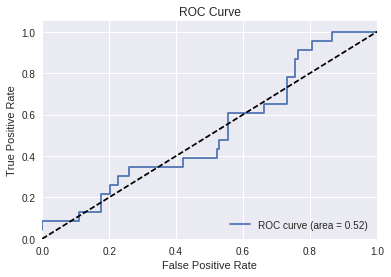

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.545 (+/- 0.032)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.518


In [137]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [ ]:
logreg_tfidf_df = full_test_df.copy()

0    23
Name: y_pred, dtype: int64

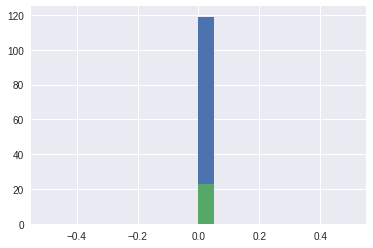

In [138]:
logreg_tfidf_df[logreg_tfidf_df.y_test == 0].y_pred.hist(bins=20)
logreg_tfidf_df[logreg_tfidf_df.y_test == 1].y_pred.hist(bins=20)
logreg_tfidf_df[logreg_tfidf_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

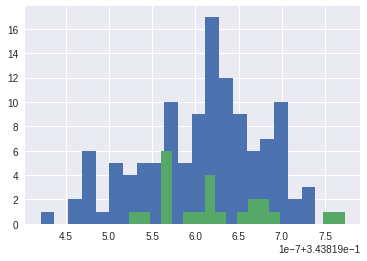

In [139]:
logreg_tfidf_df[logreg_tfidf_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg_tfidf_df[logreg_tfidf_df.y_test == 1].y_pred_proba.hist(bins=20)

In [146]:
logreg_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg_tfidf_df.y_test==1].sort_values('y_pred_proba', ascending=True)

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
10,john enregistra avec le groupe deux albums mo...,1,1,0,0.145405,1999.0,408.0
19,le sous-secteur de jausiers du secteur forti...,1,1,0,0.149305,978.0,201.0
17,"un peu plus de vingt ans plus tard, l'as de pi...",1,1,0,0.151983,558.0,101.0
20,orleans est un comté au nord-ouest de l'état d...,1,1,0,0.156286,187.0,43.0
11,"onizuka a ""preté"" son lot au pauvre type pour ...",1,1,0,0.160462,420.0,90.0
14,la ligue libérale et patriotique (en anglais...,1,1,0,0.163121,1092.0,210.0
21,"en 1675, elle devint possession de hans willem...",1,1,0,0.164955,823.0,169.0
3,"la première guerre mondiale, déclenchée par un...",1,1,0,0.166380,483.0,91.0
9,"dans l'épisode "" one of us, one of them "", tra...",1,1,0,0.169042,455.0,106.0
1,"anatole le braz , né anatole jean françois m...",1,1,0,0.175482,429.0,95.0


#### Decision tree classifier

In [206]:
clf = DecisionTreeClassifier(criterion='entropy', splitter='random')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

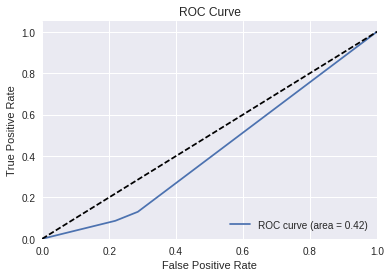

,score
precision,0.066 (+/- 0.027)
recall,0.117 (+/- 0.063)
f1,0.064 (+/- 0.078)
roc_auc,0.420 (+/- 0.040)


,test_score
precision,0.071
recall,0.087
f1,0.078
roc_auc,0.421


In [207]:
plot_roc_auc(y_test, y_pred_proba)
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [ ]:
dt_tfidf_df = full_test_df.copy()

0    21
1     2
Name: y_pred, dtype: int64

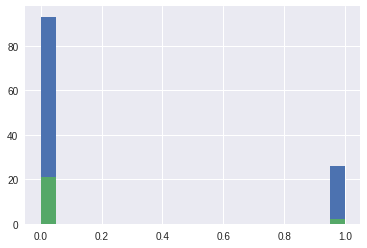

In [208]:
dt_tfidf_df[dt_tfidf_df.incoherence == 0].y_pred.hist(bins=20)
dt_tfidf_df[dt_tfidf_df.incoherence == 1].y_pred.hist(bins=20)
dt_tfidf_df[dt_tfidf_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

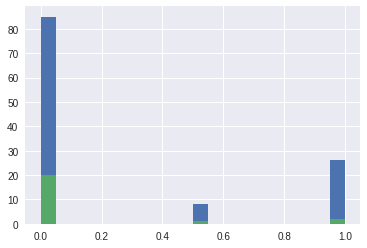

In [209]:
dt_tfidf_df[dt_tfidf_df.incoherence == 0].y_pred_proba.hist(bins=20)
dt_tfidf_df[dt_tfidf_df.incoherence == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [213]:
dt_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt_tfidf_df.y_test==1].sort_values('y_pred_proba', ascending=True)
dt_tfidf_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)

for i in [8,16]:
    print(dt_tfidf_df.loc[i,'string'])

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,la tomate ( solanum lycopersicum l.) est un...,1,1,0,0.0,587.0,118.0
20,orleans est un comté au nord-ouest de l'état d...,1,1,0,0.0,187.0,43.0
19,le sous-secteur de jausiers du secteur forti...,1,1,0,0.0,978.0,201.0
18,kovu apparait au cinéma pour la première fois ...,1,1,0,0.0,656.0,155.0
17,"un peu plus de vingt ans plus tard, l'as de pi...",1,1,0,0.0,558.0,101.0
15,"médine , de son vrai nom médine zaouiche es...",1,1,0,0.0,286.0,57.0
14,la ligue libérale et patriotique (en anglais...,1,1,0,0.0,1092.0,210.0
13,stapfer divisa son ministère en quatre section...,1,1,0,0.0,366.0,78.0
12,(depuis 2007) : vacant,1,1,0,0.0,22.0,6.0
21,"en 1675, elle devint possession de hans willem...",1,1,0,0.0,823.0,169.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
8,"à la fin de sa licence, l'étudiant bénéficie d...",1,1,1,1.0,277.0,52.0
16,alles fühlt des liebe freuden (littéralement...,1,1,1,1.0,220.0,44.0


à la fin de sa licence, l'étudiant bénéficie de nombreuses et diverses possibilités de poursuites d'études à travers toute la france : écoles de commerces, filières spécialisées dans l'économie d'entreprise, informatique, comptabilité, gestion, communication internationale ...
 alles fühlt des liebe freuden  (littéralement  ce portrait est un ravissement ) est l'air chanté lors du second acte par monostatos, le serviteur maure de sarastro, un ténor, dans l'opéra de mozart  la flûte enchantée .


Mean length of detected positive scores (character-wise and token-wise)

In [343]:
dt_tfidf_df.len[(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].mean()
dt_tfidf_df.len_tok[(dt_tfidf_df.y_test == 1)&(dt_tfidf_df.y_pred == 1)].mean()

248.5

48.0

## Method 3: Mean vectors

Function for getting mean vector of each string

In [419]:
def w2v_extractor(df, model):
    
    token_list = []
    sentence_list = []
    
    for i in range(0, df.shape[0]): # for each string
        g = 0
        for token in re.findall(string_pattern, df.loc[i,'string']): # for each token of the string
            g += 1
            if token in model.wv.vocab:
                token_list.append(np.reshape(model.wv.word_vec(token), (1, model.vector_size)))
                # add vector of each token in vocabulary to list
            else:
                continue
        #print('number tokens', g)
        
        string_matrix = np.vstack(token_list)
        #print('string_matrix.shape', string_matrix.shape)
        
        string_average = string_matrix.mean(axis=0)
        #print('string_average.shape', string_average.shape)
        
        sentence_list.append(string_average)
        token_list = []
    
    string_ave_matrix = np.vstack(sentence_list)
    #print('shape final df', string_matrix.shape)
    
    list_col = [] # generate columns labels for each of the dimensions
    for i in range(0, model.vector_size):
        list_col.append('dim_{}'.format(i))

    dim_df = pd.DataFrame(string_ave_matrix)
    dim_df.columns = list_col
    
    return dim_df

### 3.1 Vector size 100

In [423]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')

dim_df_train = w2v_extractor(df_train, model)
dim_df_test = w2v_extractor(df_test, model)

temp_df_train = pd.concat([df_train.copy(), dim_df_train], axis=1)
temp_df_test = pd.concat([df_test.copy(), dim_df_test], axis=1)

X_train = temp_df_train[temp_df_train.columns[-model.vector_size:]].values.copy()
X_test = temp_df_test[temp_df_test.columns[-model.vector_size:]].values.copy()

y_train = temp_df_train.incoherence.values.copy()
y_test = temp_df_test.incoherence.values.copy()

#### Logistic regression

In [424]:
clf = LogisticRegression(solver='sag', n_jobs=-1)#, C=0.000000001)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


CPU times: user 9.94 s, sys: 13.7 s, total: 23.7 s
Wall time: 13.8 s


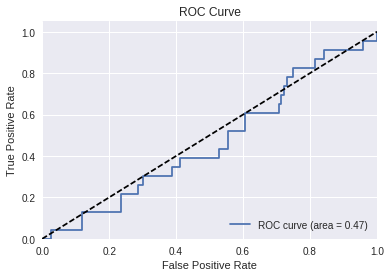

100

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.476 (+/- 0.066)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.469


In [259]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [ ]:
logreg100_mean_df = full_test_df.copy()

0    23
Name: y_pred, dtype: int64

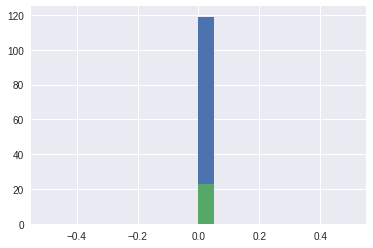

In [260]:
logreg100_mean_df[logreg100_mean_df.y_test == 0].y_pred.hist(bins=20)
logreg100_mean_df[logreg100_mean_df.y_test == 1].y_pred.hist(bins=20)
logreg100_mean_df[logreg100_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

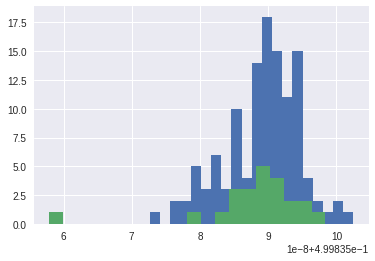

In [261]:
logreg100_mean_df[logreg100_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg100_mean_df[logreg100_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

In [263]:
logreg100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg100_mean_df.y_test==1].sort_values('y_pred_proba', ascending=True)
logreg100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_mean_df.y_test == 1)&(logreg100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
12,(depuis 2007) : vacant,1,1,0,0.499835,22.0,6.0
8,"à la fin de sa licence, l'étudiant bénéficie d...",1,1,0,0.499835,277.0,52.0
1,"anatole le braz , né anatole jean françois m...",1,1,0,0.499835,429.0,95.0
15,"médine , de son vrai nom médine zaouiche es...",1,1,0,0.499835,286.0,57.0
16,alles fühlt des liebe freuden (littéralement...,1,1,0,0.499835,220.0,44.0
20,orleans est un comté au nord-ouest de l'état d...,1,1,0,0.499835,187.0,43.0
11,"onizuka a ""preté"" son lot au pauvre type pour ...",1,1,0,0.499835,420.0,90.0
19,le sous-secteur de jausiers du secteur forti...,1,1,0,0.499835,978.0,201.0
5,l'activité économique de la ville est essntiel...,1,1,0,0.499835,311.0,55.0
7,le luxembourg a participé 37 fois au concours ...,1,1,0,0.499835,236.0,45.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


#### Decision tree classifier

In [427]:
clf = DecisionTreeClassifier()#criterion='entropy', splitter='random')#, class_weight='balanced')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

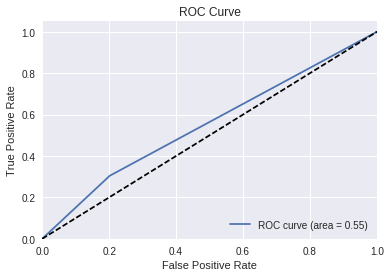

100

,score
precision,0.150 (+/- 0.057)
recall,0.208 (+/- 0.071)
f1,0.158 (+/- 0.051)
roc_auc,0.467 (+/- 0.056)


,test_score
precision,0.226
recall,0.304
f1,0.259
roc_auc,0.551


In [271]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [ ]:
dt100_mean_df= full_test_df.copy()

0    16
1     7
Name: y_pred, dtype: int64

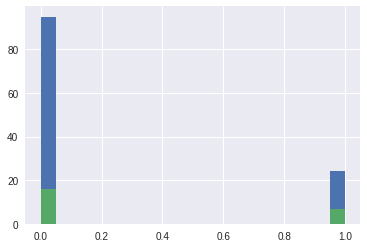

In [272]:
dt100_mean_df[dt100_mean_df.y_test == 0].y_pred.hist(bins=20)
dt100_mean_df[dt100_mean_df.y_test == 1].y_pred.hist(bins=20)
dt100_mean_df[dt100_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

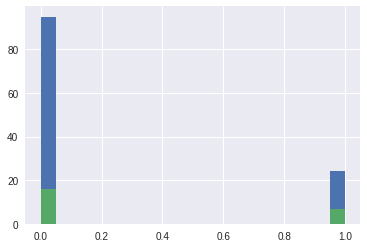

In [273]:
dt100_mean_df[dt100_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
dt100_mean_df[dt100_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [276]:
dt100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt100_mean_df.y_test==1].sort_values('y_pred_proba', ascending=True)
dt100_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100_mean_df.y_test == 1)&(dt100_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
for i in [7,8,9,11,12,18,22]:
    print(dt_bow_df.loc[i,'string'],'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,la tomate ( solanum lycopersicum l.) est un...,1,1,0,0.0,587.0,118.0
14,la ligue libérale et patriotique (en anglais...,1,1,0,0.0,1092.0,210.0
13,stapfer divisa son ministère en quatre section...,1,1,0,0.0,366.0,78.0
17,"un peu plus de vingt ans plus tard, l'as de pi...",1,1,0,0.0,558.0,101.0
21,"en 1675, elle devint possession de hans willem...",1,1,0,0.0,823.0,169.0
10,john enregistra avec le groupe deux albums mo...,1,1,0,0.0,1999.0,408.0
15,"médine , de son vrai nom médine zaouiche es...",1,1,0,0.0,286.0,57.0
19,le sous-secteur de jausiers du secteur forti...,1,1,0,0.0,978.0,201.0
6,lorsque shenron a exaucé le vœu de la personne...,1,1,0,0.0,249.0,50.0
5,l'activité économique de la ville est essntiel...,1,1,0,0.0,311.0,55.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
7,le luxembourg a participé 37 fois au concours ...,1,1,1,1.0,236.0,45.0
8,"à la fin de sa licence, l'étudiant bénéficie d...",1,1,1,1.0,277.0,52.0
9,"dans l'épisode "" one of us, one of them "", tra...",1,1,1,1.0,455.0,106.0
11,"onizuka a ""preté"" son lot au pauvre type pour ...",1,1,1,1.0,420.0,90.0
12,(depuis 2007) : vacant,1,1,1,1.0,22.0,6.0
18,kovu apparait au cinéma pour la première fois ...,1,1,1,1.0,656.0,155.0
22,la façade principale n'est pas disposée à fron...,1,1,1,1.0,159.0,34.0


le luxembourg a participé 37 fois au concours eurovision de la chanson. depuis 1994, le luxembourg ne souhaite plus y participer pour des raisons financières : cela revenait cher au grand-duché d'organiser le concours lorsqu'il gagnait. 

à la fin de sa licence, l'étudiant bénéficie de nombreuses et diverses possibilités de poursuites d'études à travers toute la france : écoles de commerces, filières spécialisées dans l'économie d'entreprise, informatique, comptabilité, gestion, communication internationale ... 

dans l'épisode " one of us, one of them ", tracy apprend la mort de niki et rencontre micah. il lui apprend que sa mère possédait une super-force et que lui peut parler aux machines. elle part ensuite à la rencontre du docteur zimmerman pour qu'il lui en apprenne plus sur ses origines. elle sonne à sa porte et celui-ci lui répond en l'appelant barbara. il se corrige en disant qu'elle est celle de beverly hills et lui révèle que c'est lui qui l'a crée. 

onizuka a "preté" son l

Mean length of accurately detected positive scores (character-wise and token-wise)

In [342]:
dt100_mean_df.len[(dt100_mean_df.y_test == 1)&(dt100_mean_df.y_pred == 1)].mean()
dt100_mean_df.len_tok[(dt100_mean_df.y_test == 1)&(dt100_mean_df.y_pred == 1)].mean()

317.85714285714283

69.71428571428571

### 3.2 Vector size 300

In [ ]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')

dim_df_train = w2v_extractor(df_train, model)
dim_df_test = w2v_extractor(df_test, model)

temp_df_train = pd.concat([df_train.copy(), dim_df_train], axis=1)
temp_df_test = pd.concat([df_test.copy(), dim_df_test], axis=1)

X_train = temp_df_train[temp_df_train.columns[-model.vector_size:]].values.copy()
X_test = temp_df_test[temp_df_test.columns[-model.vector_size:]].values.copy()

y_train = temp_df_train.incoherence.values.copy()
y_test = temp_df_test.incoherence.values.copy()

#### Logistic regression

In [431]:
clf = LogisticRegression(solver='sag', n_jobs=-1)#, C=0.000000001)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


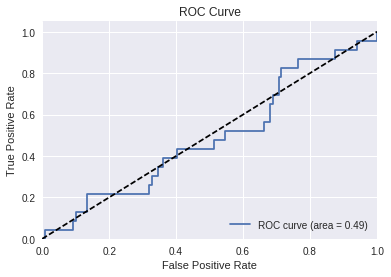

300

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.464 (+/- 0.055)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.491


In [315]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [ ]:
logreg300_mean_df = full_test_df.copy()

0    23
Name: y_pred, dtype: int64

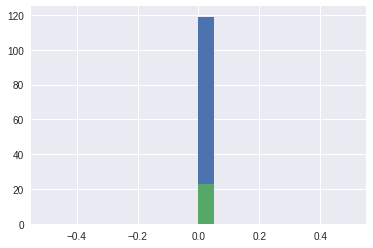

In [316]:
logreg300_mean_df[logreg300_mean_df.y_test == 0].y_pred.hist(bins=20)
logreg300_mean_df[logreg300_mean_df.y_test == 1].y_pred.hist(bins=20)
logreg300_mean_df[logreg300_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

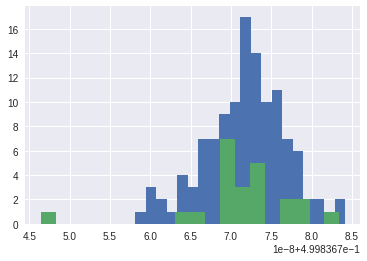

In [317]:
logreg300_mean_df[logreg300_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg300_mean_df[logreg300_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [318]:
logreg300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg300_mean_df.y_test==1].sort_values('y_pred_proba', ascending=True)
#logreg300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_mean_df.y_test == 1)&(logreg300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
#for i in [5,22]:
#    print(logreg300_mean_df.loc[i,'string'])

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
12,(depuis 2007) : vacant,1,1,0,0.499837,22.0,6.0
8,"à la fin de sa licence, l'étudiant bénéficie d...",1,1,0,0.499837,277.0,52.0
16,alles fühlt des liebe freuden (littéralement...,1,1,0,0.499837,220.0,44.0
1,"anatole le braz , né anatole jean françois m...",1,1,0,0.499837,429.0,95.0
11,"onizuka a ""preté"" son lot au pauvre type pour ...",1,1,0,0.499837,420.0,90.0
15,"médine , de son vrai nom médine zaouiche es...",1,1,0,0.499837,286.0,57.0
19,le sous-secteur de jausiers du secteur forti...,1,1,0,0.499837,978.0,201.0
7,le luxembourg a participé 37 fois au concours ...,1,1,0,0.499837,236.0,45.0
4,autoroute=a9 e=e62 e27 km=? type=repos panneau...,1,1,0,0.499837,99.0,28.0
0,la tomate ( solanum lycopersicum l.) est un...,1,1,0,0.499837,587.0,118.0


#### Decision Tree classifier

In [329]:
clf = DecisionTreeClassifier(class_weight='balanced')# criterion='entropy', splitter='random', )
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

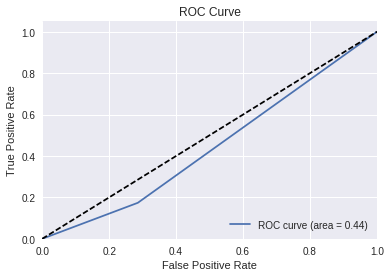

300

,score
precision,0.153 (+/- 0.048)
recall,0.167 (+/- 0.055)
f1,0.196 (+/- 0.080)
roc_auc,0.454 (+/- 0.040)


,test_score
precision,0.105
recall,0.174
f1,0.131
roc_auc,0.444


In [330]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [ ]:
dt300_mean_df = full_test_df.copy()

0    19
1     4
Name: y_pred, dtype: int64

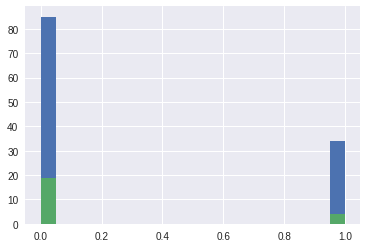

In [331]:
dt300_mean_df[dt300_mean_df.y_test == 0].y_pred.hist(bins=20)
dt300_mean_df[dt300_mean_df.y_test == 1].y_pred.hist(bins=20)
dt300_mean_df[dt300_mean_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

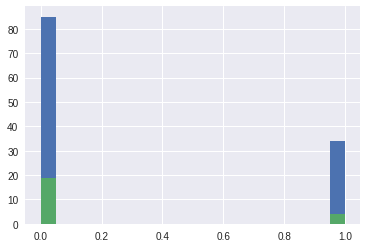

In [332]:
dt300_mean_df[dt300_mean_df.y_test == 0].y_pred_proba.hist(bins=20)
dt300_mean_df[dt300_mean_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [341]:
dt300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt300_mean_df.y_test==1].sort_values('y_pred_proba', ascending=True)
dt300_mean_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300_mean_df.y_test == 1)&(dt300_mean_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
dt300_mean_df.len[(dt300_mean_df.y_test == 1)&(dt300_mean_df.y_pred == 1)].mean()
dt300_mean_df.len_tok[(dt300_mean_df.y_test == 1)&(dt300_mean_df.y_pred == 1)].mean()

for i in [14,18,19,22]:
    print(dt300_mean_df.loc[i,'string'],'\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
0,la tomate ( solanum lycopersicum l.) est un...,1,1,0,0.0,587.0,118.0
20,orleans est un comté au nord-ouest de l'état d...,1,1,0,0.0,187.0,43.0
17,"un peu plus de vingt ans plus tard, l'as de pi...",1,1,0,0.0,558.0,101.0
16,alles fühlt des liebe freuden (littéralement...,1,1,0,0.0,220.0,44.0
15,"médine , de son vrai nom médine zaouiche es...",1,1,0,0.0,286.0,57.0
13,stapfer divisa son ministère en quatre section...,1,1,0,0.0,366.0,78.0
12,(depuis 2007) : vacant,1,1,0,0.0,22.0,6.0
21,"en 1675, elle devint possession de hans willem...",1,1,0,0.0,823.0,169.0
10,john enregistra avec le groupe deux albums mo...,1,1,0,0.0,1999.0,408.0
11,"onizuka a ""preté"" son lot au pauvre type pour ...",1,1,0,0.0,420.0,90.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
14,la ligue libérale et patriotique (en anglais...,1,1,1,1.0,1092.0,210.0
18,kovu apparait au cinéma pour la première fois ...,1,1,1,1.0,656.0,155.0
19,le sous-secteur de jausiers du secteur forti...,1,1,1,1.0,978.0,201.0
22,la façade principale n'est pas disposée à fron...,1,1,1,1.0,159.0,34.0


721.25

150.0

la  ligue libérale et patriotique  (en anglais :   en the liberal and country league  , abrégé lcl) a été, pendant ses quarante années d'existence, un des principaux partis politiques en australie-méridionale. * les classes urbaines moyennes qui soutenaient le parti mais qui ne participaient pas à sa direction. ce n'est qu'en 1955 qu'un de ses membres de cette troisième composante, robin millhouse, fut élu au parlement. millhouse, souvent considéré durant son mandat comme le membre le plus progressiste du parlement d'australie-méridionale, fut finalement exclu du lcl en 1973 pour ses critiques incessantes envers l'aile droite du parti.  le lcl perdit le gouvernement pour la première fois aux élections de 1965. il le récupéra un bref moment avec hall mais le départ de playford avait mis en évidence tous les problèmes que connaissait le parti ce qui amena au départ de l'aile progressiste du parti pour former le  mouvement libéral . après ce départ le lcl, conduit par eastick, changea de 

## Method 4: skip-gram model

In [348]:
def scores_generator(df_train, df_test, pair_fn):
    
    df_test_temp = df_test.copy()
    df_test_temp = df_test_temp.reset_index()

    df_scores = pd.DataFrame(index=df_train.index, columns=['score'])
    df_scores_test = pd.DataFrame(index=df_test_temp.index, columns=['score'])

    for i in range(0, df_train.shape[0]):
        df_scores.loc[i,'string'] = df_train.loc[i,'string']
        df_scores.loc[i,'score'] = score_sentence_sg(pair_fn, model, re.findall(string_pattern, df_train.loc[i,'string']))
        
    X_train = df_scores.score
    y_train = df_train.incoherence
    
    for i in range(0, df_test_temp.shape[0]):
        df_scores_test.loc[i,'string'] = df_test_temp.loc[i,'string']
        df_scores_test.loc[i,'score'] = score_sentence_sg(pair_fn, model, re.findall(string_pattern, df_test_temp.loc[i,'string']))
        
    X_test = df_scores_test.score
    y_test = df_test_temp.incoherence
    
    return df_scores, X_train, y_train, df_scores_test, X_test, y_test

In [445]:
def score_sentence_sg(score_sg_fn, model, sentence, work=None):
    """
    Obtain likelihood score for a single sentence in a fitted skip-gram representaion.

    The sentence is a list of Vocab objects (or None, when the corresponding
    word is not in the vocabulary). Called internally from `Word2Vec.score()`.

    This is the non-optimized, Python version. If you have cython installed, gensim
    will use the optimized version from word2vec_inner instead.
    
    """

    log_prob_sentence = 0.0
    if model.negative:
        raise RuntimeError("scoring is only available for HS=True")

    word_vocabs = [model.wv.vocab[w] for w in sentence if w in model.wv.vocab]
    for pos, word in enumerate(word_vocabs):
        if word is None:
            continue  # OOV word in the input sentence => skip

        # now go over all words from the window, predicting each one in turn
        start = max(0, pos - model.window)
        for pos2, word2 in enumerate(word_vocabs[start : pos + model.window + 1], start):
            # don't train on OOV words and on the `word` itself
            if word2 is not None and pos2 != pos:
                log_prob_sentence += score_sg_fn(model, word, word2)

    return log_prob_sentence


def score_sg_pair_original(model, word, word2):
    l1 = model.wv.syn0[word2.index]
    l2a = deepcopy(model.syn1[word.point])  # 2d matrix, codelen x layer1_size
    sgn = (-1.0)**word.code  # ch function, 0-> 1, 1 -> -1
    lprob = -np.log(1.0 + np.exp(-sgn*np.dot(l1, l2a.T)))
    return sum(lprob)

def score_sg_pair(model, word, word2):
    #print(word, word2)
    l1 = model.wv.syn0[word2.index]
    print('a >', word.point.shape, word.code.shape)
    l2 = deepcopy(model.syn1[word.point])  # 2d matrix, codelen x layer1_size

    #assert l1.shape == l2.shape
    lprob = l2 * l1
    print('b >', lprob.shape)
    return lprob

### 4.1 Vector size 100

In [446]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_100')
df_scores, X_train, y_train, df_scores_test, X_test, y_test = scores_generator(df_train, df_test, score_sg_pair_original)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

CPU times: user 13.6 s, sys: 0 ns, total: 13.6 s
Wall time: 13.6 s


/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/home/dp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


#### Logistic regression

In [355]:
clf = LogisticRegression(solver='sag', n_jobs=-1)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

CPU times: user 1.17 s, sys: 104 ms, total: 1.28 s
Wall time: 7.96 s


/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


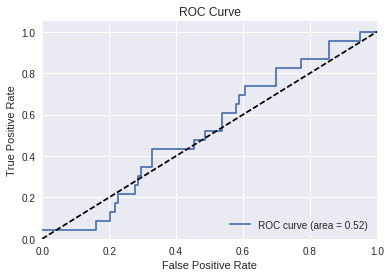

100

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.571 (+/- 0.052)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.524


In [356]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [ ]:
logreg100_sg_df = full_test_df.copy()

0    23
Name: y_pred, dtype: int64

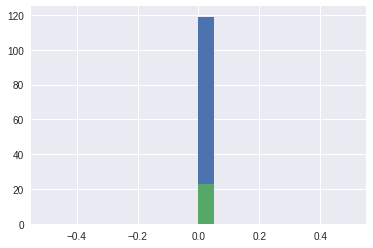

In [357]:
logreg100_sg_df[logreg100_sg_df.y_test == 0].y_pred.hist(bins=20)
logreg100_sg_df[logreg100_sg_df.y_test == 1].y_pred.hist(bins=20)
logreg100_sg_df[logreg100_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

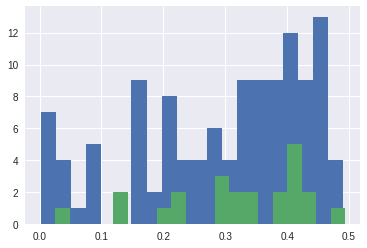

In [358]:
logreg100_sg_df[logreg100_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg100_sg_df[logreg100_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [361]:
logreg100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg100_sg_df.y_test==1].sort_values('y_pred_proba', ascending=True)
logreg100_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg100_sg_df.y_test == 1)&(logreg100_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
logreg100_sg_df.len[(logreg100_sg_df.y_test == 1)&(logreg100_sg_df.y_pred == 1)].mean()
logreg100_sg_df.len_tok[(logreg100_sg_df.y_test == 1)&(logreg100_sg_df.y_pred == 1)].mean()

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
10,john enregistra avec le groupe deux albums mo...,1,1,0,0.025597,1999.0,408.0
14,la ligue libérale et patriotique (en anglais...,1,1,0,0.141360,1092.0,210.0
19,le sous-secteur de jausiers du secteur forti...,1,1,0,0.141802,978.0,201.0
21,"en 1675, elle devint possession de hans willem...",1,1,0,0.194660,823.0,169.0
18,kovu apparait au cinéma pour la première fois ...,1,1,0,0.229649,656.0,155.0
2,la vrt (communauté flamande) dispose depuis le...,1,1,0,0.229649,582.0,129.0
17,"un peu plus de vingt ans plus tard, l'as de pi...",1,1,0,0.284316,558.0,101.0
0,la tomate ( solanum lycopersicum l.) est un...,1,1,0,0.290017,587.0,118.0
9,"dans l'épisode "" one of us, one of them "", tra...",1,1,0,0.296208,455.0,106.0
3,"la première guerre mondiale, déclenchée par un...",1,1,0,0.320225,483.0,91.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


nan

nan

#### Decision tree classifier

In [455]:
clf = DecisionTreeClassifier(max_depth=1)#,criterion='entropy')#, splitter='random', class_weight='balanced')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

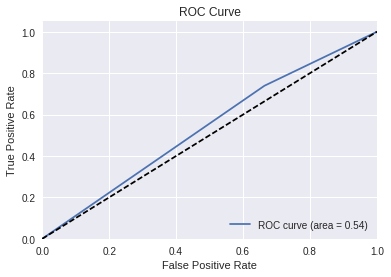

100

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.531 (+/- 0.043)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.538


In [456]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [ ]:
dt100sg_df = full_test_df.copy()

0    23
Name: y_pred, dtype: int64

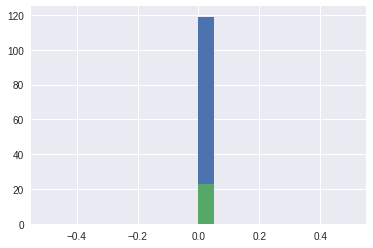

In [457]:
dt100sg_df[dt100sg_df.y_test == 0].y_pred.hist(bins=20)
dt100sg_df[dt100sg_df.y_test == 1].y_pred.hist(bins=20)
dt100sg_df[dt100sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

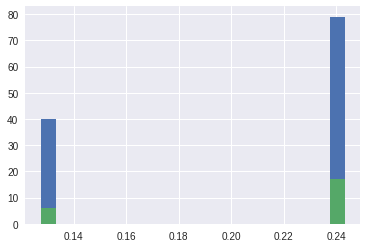

In [458]:
dt100sg_df[dt100sg_df.y_test == 0].y_pred_proba.hist(bins=20)
dt100sg_df[dt100sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [459]:
dt100sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt100sg_df.y_test==1].sort_values('y_pred_proba', ascending=True)
dt100sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt100sg_df.y_test == 1)&(dt100sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
#dt100sg_df.len[(dt100sg_df.y_test == 1)&(dt100sg_df.y_pred == 1)].mean()
#dt100sg_df.len_tok[(dt100sg_df.y_test == 1)&(dt100sg_df.y_pred == 1)].mean()
#for i in [5,22]:
#    print(dt100sg_df.loc[i,'string'], '\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
2,la vrt (communauté flamande) dispose depuis le...,1,1,0,0.127389,582.0,129.0
19,le sous-secteur de jausiers du secteur forti...,1,1,0,0.127389,978.0,201.0
18,kovu apparait au cinéma pour la première fois ...,1,1,0,0.127389,656.0,155.0
14,la ligue libérale et patriotique (en anglais...,1,1,0,0.127389,1092.0,210.0
10,john enregistra avec le groupe deux albums mo...,1,1,0,0.127389,1999.0,408.0
21,"en 1675, elle devint possession de hans willem...",1,1,0,0.127389,823.0,169.0
0,la tomate ( solanum lycopersicum l.) est un...,1,1,0,0.243309,587.0,118.0
20,orleans est un comté au nord-ouest de l'état d...,1,1,0,0.243309,187.0,43.0
17,"un peu plus de vingt ans plus tard, l'as de pi...",1,1,0,0.243309,558.0,101.0
16,alles fühlt des liebe freuden (littéralement...,1,1,0,0.243309,220.0,44.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


### 4.2 Vector size 300

In [ ]:
model = Word2Vec.load('/media/hdd/sileo/wiki-fr/text/full_filtered_language_model_300')
df_scores, X_train, y_train, df_scores_test, X_test, y_test = scores_generator(df_train, df_test, score_sg_pair_original)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

#### Logistic regression

In [436]:
clf = LogisticRegression(solver='sag', n_jobs=-1)#, C=0.000000001)
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means

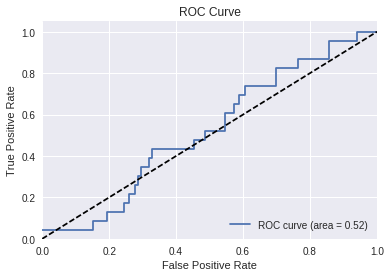

300

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.559 (+/- 0.047)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.523


In [382]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [ ]:
logreg300_sg_df = full_test_df.copy()

0    23
Name: y_pred, dtype: int64

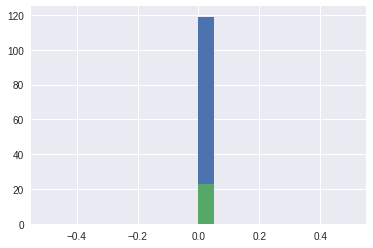

In [383]:
logreg300_sg_df[logreg300_sg_df.y_test == 0].y_pred.hist(bins=20)
logreg300_sg_df[logreg300_sg_df.y_test == 1].y_pred.hist(bins=20)
logreg300_sg_df[logreg300_sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

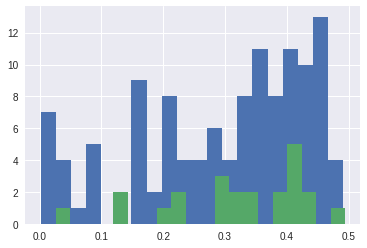

In [384]:
logreg300_sg_df[logreg300_sg_df.y_test == 0].y_pred_proba.hist(bins=20)
logreg300_sg_df[logreg300_sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [386]:
logreg300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][logreg300_sg_df.y_test==1].sort_values('y_pred_proba', ascending=True)
logreg300_sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(logreg300_sg_df.y_test == 1)&(logreg300_sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
#logreg300_sg_df.len[(logreg300_sg_df.y_test == 1)&(logreg300_sg_df.y_pred == 1)].mean()
#logreg300_sg_df.len_tok[(logreg300_sg_df.y_test == 1)&(logreg300_sg_df.y_pred == 1)].mean()
#for i in [5,22]:
#    print(logreg300_sg_df.loc[i,'string'], '\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
10,john enregistra avec le groupe deux albums mo...,1,1,0,0.025968,1999.0,408.0
19,le sous-secteur de jausiers du secteur forti...,1,1,0,0.142165,978.0,201.0
14,la ligue libérale et patriotique (en anglais...,1,1,0,0.142217,1092.0,210.0
21,"en 1675, elle devint possession de hans willem...",1,1,0,0.197669,823.0,169.0
2,la vrt (communauté flamande) dispose depuis le...,1,1,0,0.230706,582.0,129.0
18,kovu apparait au cinéma pour la première fois ...,1,1,0,0.232252,656.0,155.0
17,"un peu plus de vingt ans plus tard, l'as de pi...",1,1,0,0.284733,558.0,101.0
0,la tomate ( solanum lycopersicum l.) est un...,1,1,0,0.291848,587.0,118.0
9,"dans l'épisode "" one of us, one of them "", tra...",1,1,0,0.297440,455.0,106.0
3,"la première guerre mondiale, déclenchée par un...",1,1,0,0.319343,483.0,91.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok


#### Decision tree

In [467]:
clf = DecisionTreeClassifier(max_depth=1,criterion='entropy')#, splitter='random', class_weight='balanced')
table = cross_val_series(X_train, y_train, clf, cv_SKF)
table_test = model_testing(X_train, y_train, X_test, y_test, clf)
table_test, full_test_df, y_test, y_pred, y_pred_proba = model_testing(X_train, y_train, X_test, y_test, clf)

/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dp/anaconda3/lib/python3.6/site-packages/sklearn/metrics/class

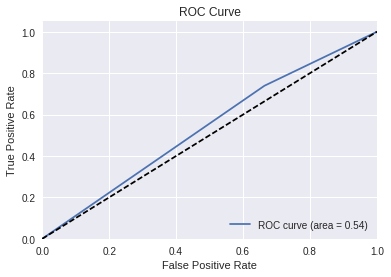

300

,score
precision,0.000 (+/- 0.000)
recall,0.000 (+/- 0.000)
f1,0.000 (+/- 0.000)
roc_auc,0.561 (+/- 0.029)


,test_score
precision,0.000
recall,0.000
f1,0.000
roc_auc,0.538


In [468]:
plot_roc_auc(y_test, y_pred_proba)
model.vector_size
table
table_test

Distribution of prediction scores for negative (blue) and positive (green) samples (default 0.5 threshold)

In [ ]:
dt300sg_df = full_test_df.copy()

0    23
Name: y_pred, dtype: int64

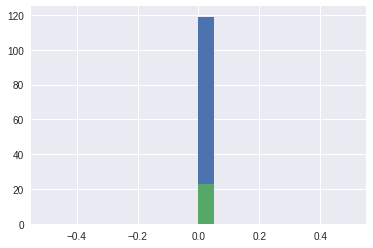

In [469]:
dt300sg_df[dt300sg_df.y_test == 0].y_pred.hist(bins=20)
dt300sg_df[dt300sg_df.y_test == 1].y_pred.hist(bins=20)
dt300sg_df[dt300sg_df.y_test == 1].y_pred.value_counts()

Distribution of prediction probability scores for negative (blue) and positive (green) samples (float between 0 and 1)

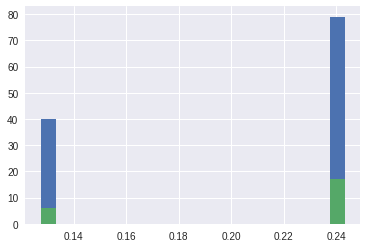

In [470]:
dt300sg_df[dt300sg_df.y_test == 0].y_pred_proba.hist(bins=20)
dt300sg_df[dt300sg_df.y_test == 1].y_pred_proba.hist(bins=20)

Display scores and detected positive samples

In [471]:
dt300sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][dt300sg_df.y_test==1].sort_values('y_pred_proba', ascending=True)
dt300sg_df[['string', 'incoherence', 'y_test', 'y_pred', 'y_pred_proba', 'len', 'len_tok']][(dt300sg_df.y_test == 1)&(dt300sg_df.y_pred == 1)].sort_values('y_pred_proba', ascending=False)
#dt300sg_df.len[(dt300sg_df.y_test == 1)&(dt300sg_df.y_pred == 1)].mean()
#dt300sg_df.len_tok[(dt300sg_df.y_test == 1)&(dt300sg_df.y_pred == 1)].mean()
#for i in [5,22]:
#    print(dt300sg_df.loc[i,'string'], '\n')

,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
2,la vrt (communauté flamande) dispose depuis le...,1,1,0,0.127389,582.0,129.0
19,le sous-secteur de jausiers du secteur forti...,1,1,0,0.127389,978.0,201.0
18,kovu apparait au cinéma pour la première fois ...,1,1,0,0.127389,656.0,155.0
14,la ligue libérale et patriotique (en anglais...,1,1,0,0.127389,1092.0,210.0
10,john enregistra avec le groupe deux albums mo...,1,1,0,0.127389,1999.0,408.0
21,"en 1675, elle devint possession de hans willem...",1,1,0,0.127389,823.0,169.0
0,la tomate ( solanum lycopersicum l.) est un...,1,1,0,0.243309,587.0,118.0
20,orleans est un comté au nord-ouest de l'état d...,1,1,0,0.243309,187.0,43.0
17,"un peu plus de vingt ans plus tard, l'as de pi...",1,1,0,0.243309,558.0,101.0
16,alles fühlt des liebe freuden (littéralement...,1,1,0,0.243309,220.0,44.0


,string,incoherence,y_test,y_pred,y_pred_proba,len,len_tok
